In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
torch.set_printoptions(edgeitems=2)

In [36]:
housing = pd.DataFrame(pd.read_csv("Housing.csv")) 
housing.head() 

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [37]:
m = len(housing) 
m 

545

In [38]:
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price'] 
Newtrain = housing[num_vars] 
Newtrain.head() 
Newtrain.shape



(545, 6)

In [39]:
x5=torch.tensor(Newtrain['area'], dtype=torch.float)
x4=torch.tensor(Newtrain['bedrooms'], dtype=torch.float)
x3=torch.tensor(Newtrain['bathrooms'], dtype=torch.float)
x2=torch.tensor(Newtrain['stories'], dtype=torch.float)
x1=torch.tensor(Newtrain['parking'], dtype=torch.float)

x1_mean=torch.mean(x1,dim=0)
x1_var=torch.var(x1,dim=0)
x1=(x1-x1_mean)/torch.sqrt(x1_var)

x2_mean=torch.mean(x2,dim=0)
x2_var=torch.var(x2,dim=0)
x2=(x2-x2_mean)/torch.sqrt(x2_var)

x3_mean=torch.mean(x3,dim=0)
x3_var=torch.var(x3,dim=0)
x3=(x3-x3_mean)/torch.sqrt(x3_var)

x4_mean=torch.mean(x4,dim=0)
x4_var=torch.var(x4,dim=0)
x4=(x4-x4_mean)/torch.sqrt(x4_var)

x5_mean=torch.mean(x5,dim=0)
x5_var=torch.var(x5,dim=0)
x5=(x5-x5_mean)/torch.sqrt(x5_var)

In [40]:
u=torch.tensor(Newtrain['price'], dtype=torch.float)
u_mean=torch.mean(u,dim=0)
u_var=torch.var(u,dim=0)
u=(u-u_mean)/torch.sqrt(u_var)

In [41]:
def model(w5,w4,w3,w2,w1,b,x5,x4,x3,x2,x1):
    return w5*x5*5+w4*x4*4+w3*x3*3+w2*x2*2+w1*x1+b

In [42]:
def loss_fn(wx, u):
    squared_diffs = (wx - u)**2
    return squared_diffs.mean()

In [43]:
params = torch.tensor([1.0,1,1,1,1,1], requires_grad=True)

In [44]:
params.grad is None

True

In [45]:
params.dtype

torch.float32

In [46]:
loss = loss_fn(model(*params,x5,x4,x3,x2,x1), u)
loss.backward()



In [47]:
params.grad

tensor([61.6254, 51.6729, 34.5990, 18.5961,  7.1093,  2.0000])

In [48]:
if params.grad is not None:
    params.grad.zero_()

In [49]:
def training_loop(n_epochs, learning_rate, params, wx, u):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:  # <1>
            params.grad.zero_()
        
        wx = model(*params,x5,x4,x3,x2,x1) 
        loss = loss_fn(wx, u)
        loss.backward()
        
        with torch.no_grad():  # <2>
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [56]:
params=training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0,1,1,1,1,1], requires_grad=True), # <1> 
    wx = model(*params,x5,x4,x3,x2,x1), # <2> 
    u = u)

Epoch 500, Loss 0.437613
Epoch 1000, Loss 0.437613
Epoch 1500, Loss 0.437613
Epoch 2000, Loss 0.437613
Epoch 2500, Loss 0.437613
Epoch 3000, Loss 0.437613
Epoch 3500, Loss 0.437613
Epoch 4000, Loss 0.437613
Epoch 4500, Loss 0.437613
Epoch 5000, Loss 0.437613


In [57]:
params

tensor([ 7.6834e-02,  1.6554e-02,  1.0152e-01,  1.2706e-01,  1.7393e-01,
        -6.7051e-08], requires_grad=True)

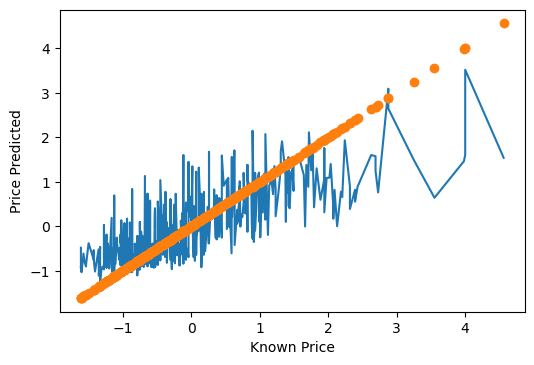

In [60]:
from matplotlib import pyplot as plt

wx = model(*params,x5,x4,x3,x2,x1)  # <1>

fig = plt.figure(dpi=100)
plt.xlabel("Known Price (normalized)")
plt.ylabel("Price Predicted (normalized)")
plt.plot(u.numpy(), wx.detach().numpy()) # <2>
plt.plot(u.numpy(), u.numpy(), 'o')
plt.savefig("Price.png", format="png") 